In [34]:
import pandas as pd
import scanpy as sc

import seaborn as sns

In [2]:
adata = sc.read_h5ad("/home/ubuntu/frameshift-1/data/combined_adata.h5ad", backed='r')

In [5]:
drug = ['Adagrasib', 'DMSO_TF']
adata = adata[adata.obs['drug'].isin(drug), :].to_memory()

In [7]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# Note: Fixed a bug in the pasted code - should be adata_mem not drug_data
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [9]:
adata_hvg = adata[:, adata.var['highly_variable']].copy()

(64895, 2000)

In [10]:
sc.tl.pca(adata_hvg)
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)


In [13]:
sc.tl.umap(adata_hvg)

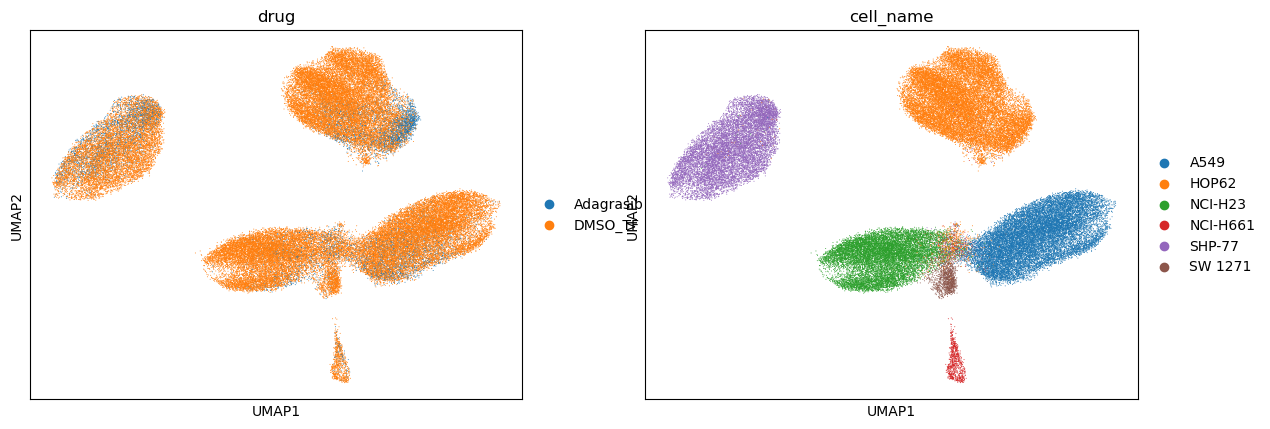

In [14]:
sc.pl.umap(adata_hvg, color=['drug', 'cell_name'])

### Trying with important genes

In [15]:
importance = pd.read_csv('/home/ubuntu/frameshift-1/carlota/augur_allcellines/feature_importances_plate9_Adagrasib.csv')
importance

,genes,feature_importances,subsample_idx,fold,cell_type,drug
0,ENSG00000261369,0.000825,0,0,A549,Adagrasib
1,PTPRG-AS1,0.000000,0,0,A549,Adagrasib
2,ZNF426,0.002204,0,0,A549,Adagrasib
3,CDK2AP2,0.001823,0,0,A549,Adagrasib
4,TSC22D3,0.000000,0,0,A549,Adagrasib
...,...,...,...,...,...,...
8876803,GDA,0.000000,49,2,NCI-H596,Adagrasib
8876804,SLC39A14,0.005244,49,2,NCI-H596,Adagrasib
8876805,MAU2,0.000481,49,2,NCI-H596,Adagrasib
8876806,SP110,0.000000,49,2,NCI-H596,Adagrasib


In [22]:
# importance.drop_duplicates(subset=['gene', ''])
imp_mean = importance.groupby(['genes', 'cell_type'])['feature_importances'].mean().reset_index()
print(imp_mean.shape)
imp_mean.head()

(215641, 3)


,genes,cell_type,feature_importances
0,7SK,A-427,0.002347
1,7SK,AN3 CA,0.002652
2,7SK,BT-474,0.004019
3,7SK,J82,0.003523
4,7SK,LOX-IMVI,0.002996


In [24]:
imp_mean[['genes', 'cell_type']].duplicated().sum()

0

In [44]:
#convert imp mean to a matrix
imp_matr = imp_mean.pivot(index='cell_type', columns='genes', values='feature_importances')
#drop any genes that are all NA
print(imp_matr.shape)
imp_matr = imp_matr.dropna(axis=0, how='all').fillna(0)
print(imp_matr.shape)

(50, 23793)
(50, 23793)


In [43]:
imp_matr = imp_matr.loc[:, (imp_matr > 0.001).sum() > 0]
print(imp_matr.shape)

(50, 7274)


In [45]:
imp_matr.to_csv("/home/ubuntu/frameshift-1/data/outs/feature_importances_plate9_Adagrasib.csv")

/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ubuntu/miniforge3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


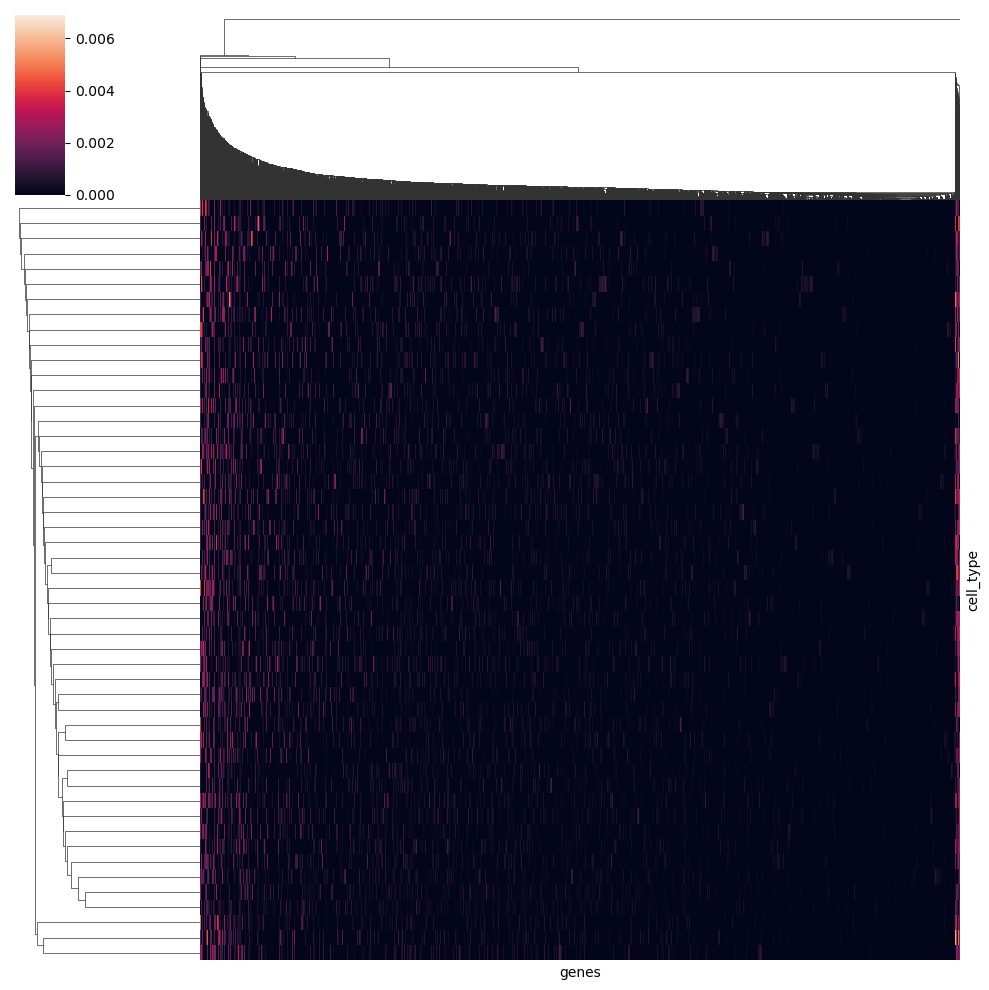

In [40]:
sns.clustermap(imp_matr, xticklabels=False, yticklabels=False)

In [46]:
cell_picked = ['NCI-H661', 'SW 1271', 'HOP62', 'NCI-H23', 'A549', 'SHP-77']
print(imp_matr.shape)

(50, 23793)


In [48]:
## open parquet in python
path = f"/home/ubuntu/frameshift-1/data/cell_line_metadata.parquet"
cl_meta = pd.read_parquet(path, engine='pyarrow')
cl_meta.head(2)

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor


In [50]:
df = imp_matr.copy()
m_meta = pd.DataFrame(columns=['label'], index=df.index)
	# mse_meta
#label if kras, krasg12c, or not
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
kras_driven = kras_driven[kras_driven['cell_name'].isin(df.index)]
# kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")

# kras_driven
g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")['cell_name']
m_meta.loc[g12c, 'label'] = 'KRAS_G12C'

not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'")['cell_name']
m_meta.loc[not_g12c, 'label'] = 'KRAS_Other'

# len(g12c), len(not_g12c), not kras
not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")['cell_name'].unique()
# # #drop any cell lines that have BRAF
# braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
# krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated")['cell_name'].unique()
# krasNo_brafYes = not_kras_driven.query("cell_name in @braf_mutated")['cell_name'].unique()
# # krasNo_brafNo
# m_meta.loc[m_meta.index.isin(krasNo_brafNo), 'label'] = 'not_kras_not_braf'
# m_meta.loc[m_meta.index.isin(krasNo_brafYes), 'label'] = 'not_kras_braf'

m_meta.loc[m_meta.index.isin(not_kras_driven), 'label'] = 'No_KRAS'

print(m_meta['label'].value_counts(dropna=False))

label
No_KRAS       26
KRAS_Other    18
KRAS_G12C      6
Name: count, dtype: int64


In [52]:
kras_agg = imp_matr.groupby(m_meta['label']).mean()
kras_agg

genes,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
label,,,,,,,,,,,,,,,,,,,,,
KRAS_G12C,0.000344,0.000099,0.000032,0.000104,0.000120,0.000037,0.000000,0.000028,0.000167,0.000000,...,0.000000,0.000096,0.000000,0.000074,0.000000,0.000170,0.000000,0.000000,0.000095,0.000092
KRAS_Other,0.000395,0.000061,0.000018,0.000052,0.000241,0.000000,0.000017,0.000086,0.000055,0.000076,...,0.000052,0.000045,0.000029,0.000053,0.000055,0.000000,0.000037,0.000057,0.000010,0.000100
No_KRAS,0.000507,0.000048,0.000029,0.000077,0.000370,0.000024,0.000013,0.000133,0.000104,0.000012,...,0.000089,0.000062,0.000000,0.000064,0.000063,0.000105,0.000016,0.000031,0.000137,0.000023


In [53]:
kras_agg.to_csv("/home/ubuntu/frameshift-1/data/outs/feature_importances_plate9_Adagrasib_KRAS_categories.csv")

In [55]:
### Top 500 for 
genes = kras_agg.loc['KRAS_G12C'].nlargest(500).index
genes

Index(['HSPA5', 'MT2A', 'TM4SF1', 'IMMP2L', 'FAM13A', 'HSP90AA1', 'MAP4K4',
       'STC1', 'EFNA5', 'NAMPT',
       ...
       'PLSCR1', 'SLC25A37', 'PMAIP1', 'KLF10', 'RAB18', 'SPRY4', 'GRIK2',
       'ZFP36', 'NRP1', 'PELI1'],
      dtype='object', name='genes', length=500)

In [67]:
adata_kras = adata[:, genes].copy()
sc.tl.pca(adata_kras)
sc.pp.neighbors(adata_kras)
sc.tl.umap(adata_kras)

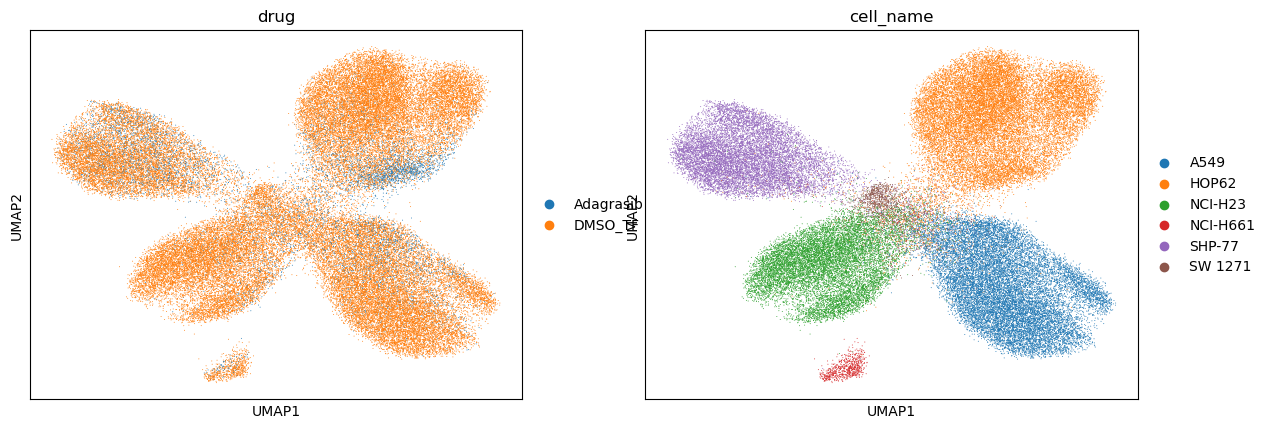

In [68]:
sc.pl.umap(adata_kras, color=['drug', 'cell_name'])

In [65]:
pscores = pd.read_csv('/home/ubuntu/frameshift-1/data/Plots_no_covariates/Program_loadings.csv', index_col=0)
ranked_genes = pscores.loc[:, '11'].sort_values()

In [66]:
ranked_genes

gene_name
PARP4P3           -2.367730
ENSG00000285330   -2.066653
TRPA1             -2.042027
TREM1             -2.027125
EPS15P1           -2.015911
                     ...   
CEACAM22P          2.720603
ENSG00000232895    2.856630
MOBP               2.973084
ENSG00000287914    3.040935
SLC39A2            3.410826
Name: 11, Length: 62710, dtype: float64